<a href="https://colab.research.google.com/github/Roon311/JpegCompression/blob/main/jpegFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://zewailcity.edu.eg/main/images/logo3.png)

_Prepared by_  [**Noureldin Mohamed Abdelsalam**](mailto:s-noureldin.hamedo@zewailcity.edu.eg)



##Imports

In [62]:
import numpy as np
import seaborn as sns


In [63]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [64]:
pip install dahuffman #This is the huffman library for python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
from dahuffman import HuffmanCodec

##***DCT***

The following is the DCT code 

In [66]:
import math as m
def dct(block):
 block = np.array(block)
 block=block.reshape(8,8)
 rows = len(block)    # set the number of rows in the block
 cols = len(block[0]) # set the number of coloumns in the block
 basis=np.zeros( (8, 8))
 dct_result=np.zeros( (8, 8))
 if rows!=8 or cols!=8:
    print('Error in block size');
 for u in range(8):
   for v in range(8):
     for x in range(8):
       for y in range(8):
         basis[x,y]=(m.cos((1/16)*(2*x+1)*u*m.pi))*(m.cos((1/16)*(2*y+1)*v*m.pi))
     #print('This is the block* basis{}'.format(block * basis))
     dct_result[u,v]=sum(sum(block * basis))
 #Scaling    
 dct_result[0,0]=(1/64)*dct_result[0,0]
 dct_result[0,1:8]=(1/32)*dct_result[0,1:8]
 dct_result[1:8,0]=(1/32)*dct_result[1:8,0]
 dct_result[1:8,1:8]=(1/16)*dct_result[1:8,1:8] 
 return dct_result

##***IDCT***

The following is the Inverse discrete cosine transform function.

In [67]:
import math as m
def idct(block):
 block = np.array(block)
 block=block.reshape(8,8)
 rows = len(block)    # set the number of rows in the block
 cols = len(block[0]) # set the number of coloumns in the block
 basis=np.zeros( (8, 8))
 idct_result=np.zeros( (8, 8))
 if rows!=8 or cols!=8:
    print('Error in block size');
 for u in range(8):
   for v in range(8):
     for x in range(8):
       for y in range(8):
         basis[x,y]=(m.cos((1/16)*(2*x+1)*u*m.pi))*(m.cos((1/16)*(2*y+1)*v*m.pi))
     #print('This is the block* basis{}'.format(block * basis))
     idct_result=idct_result+block[u,v]*basis
 return idct_result

##***Importing the image***

Use the Tiff library to read the image.

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fde2c6fba50>)

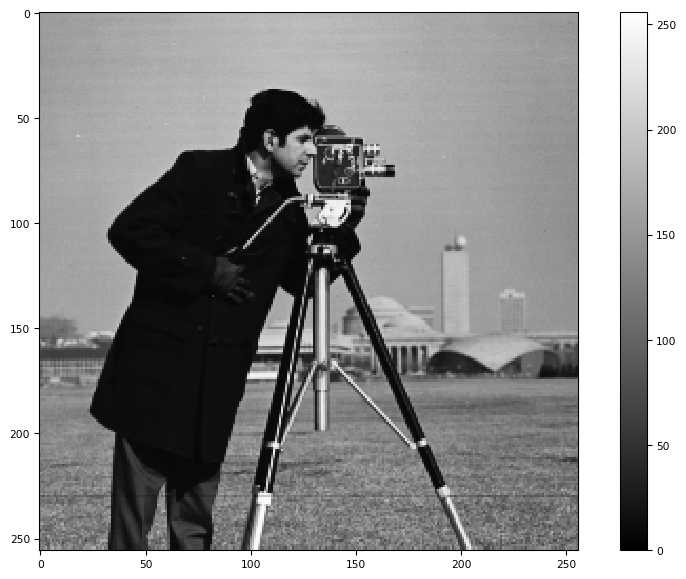

In [68]:
import tifffile as tiff
img = tiff.imread("/content/drive/MyDrive/colab photos/cameraman.tif")
tiff.imshow(img, cmap='gray')

##***Zigzag 2D to 1D transformation***
![alt text](https://www.researchgate.net/publication/358515934/figure/fig4/AS:1122586629021699@1644656917359/Path-followed-in-a-matrix-to-transform-it-into-a-vector-via-Z_Q320.jpg)


Lets formulate this as a 2 part game. Assume that there is a player standing at initial position (0,0) This player can move up,down,right, and left.

*   **Right** increment the coloumn index by 1.
*   **Left** decrements the coloumn index by 1.
*   **Up**  decrements the row index by 1
*   **Down**  increments the row index by 1

The player initially steps 1 step to the right and pushes the current value of the array to the list we are filling. The player then keeps moving down and left then pushes the value to the array until he collides with the border line(coloumn =0).Then he starts taking a step to the right and pushes the value. The player then keeps moving right then up and pushes the value at the current index, he keeps doing so until he collides with the top border(row=0).He keeps repeating the action until reaching the last row and the first coloumn. Here the player needs to switch his movement, he moves a step to the right and pushes the value to the same array. The player then needs to move right then up and pushes the value untilhe collides with the right border line(coloumn=last coloumn).After reaching the last coloumn he steps a step down then pushes the value, then he needs to take a step down then a step to the left,pushes the value. He keeps doing so until he reaches the bottom border line(row= final row).He keeps doing so and HOLA! we have our 2D array into a 1D array.

In [69]:
def zigRead(Block):
  l=[]#list to be filled with 1D array
  r=0#current Row
  c=0#current coloumn
  rows = len(Block)    # set the number of rows in the block
  cols = len(Block[0]) # set the number of coloumns in the block
  def right(c):
    c+=1
    return c
  def left(c):
    c-=1 
    return c
  def up(r):
    r-=1
    return r
  def down(r):
    r+=1
    return r 
  #if you are in col 0 move right up and read until you reach row zero
  #if you are in row 0 move down left and read until you reach col 0
  #move 1 to the right, if you reach row 8 stop
  l.append(Block[r,c])
  while r<(rows-1):
    if r==0:
      c=right(c)
      l.append(Block[r,c])
      while(c!=0):
        r=down(r)
        c=left(c)
        l.append(Block[r,c])
    elif c==0:
      r=down(r)
      l.append(Block[r,c])
      while(r!=0):
        c=right(c)
        r=up(r)
        l.append(Block[r,c])
  #Here comes the second half to be read
  #if you are in col 8 move down then move left down and read until you reach row 8
  #if you are in row 8 move right then move right up and read until you reach col 0
  while (r!=(rows-1)) or (c!=(cols-1)): #as long as we didn't reach the last element
    if r==(rows-1):
      c=right(c)
      l.append(Block[r,c])
      while(c!=(cols-1)):
        c=right(c)
        r=up(r)
        l.append(Block[r,c])
    elif c==(cols-1):
      r=down(r)
      l.append(Block[r,c])
      while(r!=(rows-1)):
        c=left(c)
        r=down(r)
        l.append(Block[r,c])
  l=np.array(l)

  return l

##Step 1: ***Divide the image into blocks of 8x8***

In [70]:
print(img.shape)
img

(256, 256)


array([[156, 159, 158, ..., 151, 152, 152],
       [160, 154, 157, ..., 154, 155, 153],
       [156, 159, 158, ..., 151, 152, 152],
       ...,
       [114, 132, 123, ..., 135, 137, 114],
       [121, 126, 130, ..., 133, 130, 113],
       [121, 126, 130, ..., 133, 130, 113]], dtype=uint8)

The following function is responsible to divide any image into 8x8 blocks.
To determine how many loops will be done on the coloumns and the rows the for loops will be done on range of the length of the image divided by the window size which is 8 for the rows and coloumns. The current image used for testing is 256x256 taking blocks of 8, means that we have 32x32 blocks of 8x8.
The index of the block will be multiplied by the row window size to be the initial cutting position of the row, and the same index will be multiplied by the row window size then the row window size will be added to determine the final cut position for the row, same for coloumns.

***i*** is the row index of the block in the 32 blocks.

***j*** is the coloumn index of the block in the 32 blocks.
*   row cut from: i*(windowR)
*   row cut to: i*(windowR)+windowR
*   col cut from: j*(windowC)
*   col cut to: j*(windowC)+windowC



In [71]:
def img_divider(img,windowR,windowC):
  blocklist=[]#list where the blocks will be added
  #windowR: length of rows of the window 
  #windowC: lenth of columns of the window
  for i in range(len(img)//windowR):
    for j in range(len(img[0])//windowC):
      b=img[i*(windowR):((i*(windowR))+windowR),j*(windowC):((j*(windowC))+windowC)]
      blocklist.append(b)
  blocklist=np.array(blocklist)
  return blocklist

Now blocks contain the image divided into 8 by 8 blocks, for our cameraman image which is 256x256, we will have 32x32 blocks of 8 which would be 1024 if converted into 1 d array of blocks of 8x8

##Step 2: ***Perform DCT for each***

In [72]:
blocks=img_divider(img,8,8)

In [73]:
blocks#array of blocks
dct_blocks=[]
for i in blocks:
  dct_blocks.append(dct(i))

##Step 3: ***Perform Quantization***


In [74]:
def Quantization(x):
  if x==1:
      Table = [[1,1,1,1,1,2,2,4],
          [1,1,1,1,1,2,2,4],
          [1,1,1,1,2,2,2,4],
          [1,1,1,1,2,2,4,8],
          [1,1,2,2,2,2,4,8],
          [2,2,2,2,2,4,8,8],
          [2,2,2,4,4,8,8,16],
          [4,4,4,4,8,8,16,16]]
      return Table
  elif x==2:
      Table=[[1,2,4,8,16,32,64,128],
          [2,4,4,8,16,32,64,128],
          [4,4,8,16,32,64,128,128],
          [8,8,16,32,64,128,128,256],
          [16,16,32,64,128,128,256,256],
          [32,32,64,128,128,256,256,256],
          [64,64,128,128,256,256,256,256],
          [128,128,128,256,256,256,256,256]]
      return Table
  

We will now divide by the quantization table for every 8*8 block.
We will do it once for the low frequency quantization table, and once for the high frequency quantization table.

In [75]:
LQ=[]#array to be filled with values after dividing by the low frequency quntization table
HQ=[]#array to be filled with values after dividing by the high frequency of the quantization table
for i in dct_blocks:
  LQ.append(i/Quantization(1))
  HQ.append(i/Quantization(2))
LQ=np.array(LQ)
LQ=np.round(LQ)
HQ=np.round(HQ)

##Step 4: ***Transform each block from 2-D into 1-D vector using the following pattern***


In [76]:
LQ_zig=[]#array to be filled with 1D values of the low frequency quntization table
HQ_zig=[]#array to be filled with 1D values of the high frequency quntization table
for blck in LQ:
  LQ_zig.append(zigRead(blck))
for blck in HQ:
  HQ_zig.append(zigRead(blck))

## Step 5: ***Use run-length encoding to compress any stream of zeros***

We take a 1 D array and loop over it, if a zero is found  counter would be incremented by one, then we will continue looping until a non-zero is found. When this non zero is found, if the counter is not zero we will append a zero then the counter value, followed by the non-zero value found. After doing so, we will set the counter value back to zero. If a non zero vaalue is received and the counter value is zero, then we should just push the non zero value to our array.

In [77]:
def runlength(array):
  counter=0
  arrnew=[]
  for index,i in enumerate(array):
    if i==0 :
      counter+=1
      if index==len(array)-1:
        #this is the last element
        arrnew.append(0); arrnew.append(counter);

    elif counter!=0:
         arrnew.append(0)#push zero
         arrnew.append(counter)#push zero 
         arrnew.append(i)
         counter=0
    else:
      arrnew.append(i) 
  return arrnew

We Will apply runlength code to all elements of both arrays.

In [78]:
runl=[]#array containing runlength codes for the low freq quantization table
for i in LQ_zig:
 runl.append(runlength(i))
np.array(runl)
all=np.concatenate( runl, axis=0 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [79]:
runlH=[]#array containing runlength codes for the high freq quantization table
for i in HQ_zig:
 runlH.append(runlength(i))
np.array(runlH)
allH=np.concatenate( runlH, axis=0 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


## Step 6: ***Use Huffman to encode the final astream***

This is encoding using the online dhuffman library. Encoding will be done for both arrays(low and high freq)

In [80]:
codec = HuffmanCodec.from_data(all)#form the frequency array that will be used for encoding and decoding.
encoded=[]
for i in  runl:
  encoded.append(codec.encode(i))

In [81]:
codecH = HuffmanCodec.from_data(allH)
encodedH=[]
for i in  runlH:
  encodedH.append(codecH.encode(i))

This is the compresion ratio for both arrays

In [82]:
compression_ratio_L=(img.shape[0]*img.shape[1]*8)/(len(encoded)*8)
compression_ratio_L

64.0

In [83]:
compression_ratio_H=img.shape[0]*img.shape[1]*8/(len(encodedH)*8)
compression_ratio_H

64.0

## Step 7: ***Decode using Huffman Decoder with the same freq table used***

In [84]:
decoded=[]
for i in encoded:
  decoded.append(codec.decode(i))
decoded=np.array(decoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [85]:
decodedH=[]
for i in encodedH:
  decodedH.append(codecH.decode(i))
decodedH=np.array(decodedH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


## Step 8: ***Run length code decoding***

To runlength decode the arrays we will search for zeros, once a zero is found we will append zeros by number equal to the next element which is the counter and set a flag to tre to prevent saving the counter into the array. If the flag is true, we will set it to false.If a number which is not zero is found we will append it normally to the array.

In [86]:
def runlengthdecode(array):
  array=np.array(array)
  arrnew=[]
  flag=False
  for index,i in enumerate(array):
    print(i)
    if int(i)==0:
      #if(index<len(array)-1):#weill never happen. I added it for debugging issues
        for j in range(int(array[index+1])):
            arrnew.append(0);
        flag=True    
    elif flag==True:
      flag=False
    else:
      arrnew.append(i) 
  return arrnew

In [87]:
decodedRL=[]
for i in decoded:
  decodedRL.append(runlengthdecode(i))
decodedRL=np.array(decodedRL)

Streaming output truncated to the last 5000 lines.
2.0
-2.0
-3.0
1.0
5.0
1.0
2.0
-3.0
4.0
-3.0
2.0
-7.0
3.0
0.0
1.0
2.0
-1.0
1.0
-3.0
-3.0
-1.0
-3.0
1.0
4.0
0.0
1.0
2.0
-1.0
4.0
-3.0
0.0
1.0
-1.0
0.0
2.0
2.0
-1.0
-1.0
0.0
2.0
-1.0
0.0
7.0
128.0
5.0
-1.0
-2.0
2.0
1.0
4.0
-8.0
-1.0
-4.0
-2.0
5.0
0.0
1.0
-2.0
3.0
2.0
4.0
3.0
0.0
1.0
4.0
-1.0
-1.0
2.0
-2.0
4.0
1.0
1.0
1.0
1.0
0.0
2.0
-1.0
-2.0
-2.0
0.0
4.0
-3.0
2.0
-1.0
-3.0
0.0
1.0
-1.0
0.0
1.0
-1.0
0.0
2.0
-1.0
2.0
0.0
1.0
1.0
1.0
0.0
1.0
-1.0
0.0
9.0
128.0
1.0
-5.0
0.0
1.0
-6.0
1.0
-9.0
3.0
-7.0
-5.0
-5.0
0.0
1.0
-2.0
7.0
-1.0
1.0
7.0
6.0
-4.0
-5.0
1.0
0.0
1.0
-4.0
1.0
0.0
2.0
1.0
3.0
0.0
2.0
-4.0
1.0
0.0
1.0
1.0
0.0
3.0
1.0
-1.0
1.0
-1.0
-5.0
0.0
1.0
-1.0
1.0
5.0
0.0
1.0
-1.0
0.0
2.0
-1.0
0.0
1.0
-1.0
0.0
11.0
128.0
4.0
5.0
-3.0
0.0
1.0
8.0
4.0
-1.0
-3.0
-2.0
2.0
1.0
-1.0
-4.0
-3.0
1.0
3.0
3.0
-4.0
6.0
1.0
0.0
1.0
2.0
-3.0
6.0
1.0
0.0
1.0
1.0
-1.0
-1.0
-2.0
-2.0
4.0
1.0
3.0
0.0
2.0
-1.0
-1.0
-2.0
-1.0
0.0
3.0
2.0
-3.0
0.0
2.0
-1.0
0.0


In [88]:
decodedRH=[]
for i in decodedH:
  decodedRH.append(runlengthdecode(i))
decodedRH=np.array(decodedRH)

Streaming output truncated to the last 5000 lines.
0.0
2.0
-2.0
10.0
-2.0
0.0
1.0
-1.0
0.0
6.0
1.0
-1.0
0.0
44.0
178.0
-8.0
8.0
-4.0
6.0
-2.0
0.0
1.0
4.0
-5.0
1.0
0.0
1.0
1.0
-1.0
1.0
0.0
50.0
182.0
6.0
5.0
-3.0
-5.0
-2.0
0.0
1.0
3.0
3.0
1.0
0.0
1.0
-1.0
-1.0
-1.0
0.0
50.0
131.0
5.0
32.0
-1.0
4.0
2.0
1.0
-4.0
-8.0
-1.0
0.0
8.0
1.0
1.0
0.0
44.0
107.0
6.0
9.0
3.0
2.0
0.0
2.0
1.0
2.0
1.0
0.0
54.0
68.0
-3.0
9.0
2.0
0.0
1.0
1.0
0.0
1.0
1.0
3.0
1.0
0.0
1.0
2.0
0.0
52.0
80.0
5.0
6.0
0.0
1.0
2.0
1.0
1.0
-1.0
1.0
0.0
2.0
1.0
0.0
52.0
127.0
-9.0
-4.0
0.0
1.0
3.0
-2.0
0.0
1.0
-4.0
-1.0
-1.0
0.0
1.0
1.0
1.0
0.0
1.0
-1.0
0.0
49.0
128.0
5.0
0.0
1.0
-2.0
-4.0
2.0
0.0
1.0
-1.0
2.0
0.0
2.0
-1.0
1.0
-1.0
0.0
50.0
131.0
-4.0
-2.0
-1.0
4.0
0.0
1.0
1.0
1.0
-3.0
0.0
1.0
-1.0
0.0
53.0
100.0
29.0
6.0
2.0
-8.0
-8.0
0.0
1.0
-4.0
1.0
1.0
0.0
2.0
1.0
3.0
0.0
2.0
-1.0
0.0
47.0
13.0
1.0
0.0
62.0
13.0
0.0
63.0
14.0
0.0
1.0
1.0
0.0
61.0
14.0
0.0
63.0
14.0
0.0
63.0
13.0
1.0
0.0
62.0
14.0
0.0
63.0
14.0
0.0
63.0
106.0
-

## Step 9: ***Transform the 1-D vector into groups of 8x8 matrices***

This is opposit procedure to the zigRead described above.

In [89]:
def unzigRead(Block):
  l=[[0 for col in range(8)] for row in range(8)]#create empty list 8*8
  l=np.array(l)#convert the list into numpy array
  r=0#row counter
  c=0#coloumn counter
  rows = 8#m.sqrt(len(Block))   # set the number of rows in the block
  cols = 8#m.sqrt(len(Block[0])) # set the number of coloumns in the block
  counter=1
  def right(c):
    c+=1
    return c
  def left(c):
    c-=1 
    return c
  def up(r):
    r-=1
    return r
  def down(r):
    r+=1
    return r 
  #if you are in col 0 move right up and read until you reach row zero
  #if you are in row 0 move down left and read until you reach col 0
  #move 1 to the right, if you reach row 8 stop
  l[r,c]=Block[0]
  while r<(rows-1):
    if r==0:
      c=right(c)
      l[r,c]=Block[counter]
      counter+=1
      while(c!=0):
        r=down(r)
        c=left(c)
        l[r,c]=Block[counter]
        counter+=1
    elif c==0:
      r=down(r)
      l[r,c]=Block[counter]
      counter+=1
      while(r!=0):
        c=right(c)
        r=up(r)
        l[r,c]=Block[counter]
        counter+=1
  #Here comes the second half to be read
  #if you are in col 8 move down then move left down and read until you reach row 8
  #if you are in row 8 move right then move right up and read until you reach col 0
  while (r!=(rows-1)) or (c!=(cols-1)): #as long as we didn't reach the last element
    if r==(rows-1):
      c=right(c)
      l[r,c]=Block[counter]
      counter+=1
      while(c!=(cols-1)):
        c=right(c)
        r=up(r)
        l[r,c]=Block[counter]
        counter+=1
    elif c==(cols-1):
      r=down(r)
      l[r,c]=Block[counter]
      counter+=1
      while(r!=(rows-1)):
        c=left(c)
        r=down(r)
        l[r,c]=Block[counter]
        counter+=1

  return l

In [90]:
decoded2D=[]
for i in decodedRL:
  decoded2D.append(unzigRead(i))
decoded2D

[array([[157,   0,   0,   0,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   1,   0,   0,   0,   0,   0],
        [ -1,   0,  -1,   0,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]]),
 array([[158,  -1,   1,   1,   0,   0,   0,   0],
        [  1,   0,  -1,   0,  -1,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0],
        [ -1,  -1,   1,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]]),
 array([[161,  -1,   0,   0,   0,   0,   0,   0],
        [  1,   0,   1,   1,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0],
        [ -1,   0,   0,   0,   0,   0,   0,   

In [91]:
decoded2DH=[]
for i in decodedRH:
  decoded2DH.append(unzigRead(i))
decoded2DH

[array([[157,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]]),
 array([[158,  -1,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]]),
 array([[161,   0,   0,   0,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## Step 10: ***Multiply each group by the quantization tables***

In [92]:
dec=[]
for i in decoded2D:
   dec.append(i*Quantization(1))

In [93]:
decH=[]
for i in decoded2DH:
   decH.append(i*Quantization(1))

## Step 11: ***Perform IDCT using your own developed function on each 8x8 pixel group***


In [94]:
idct_blocks=[]
for i in dec:
  idct_blocks.append(idct(i))

In [95]:
idct_blocks_H=[]
for i in decH:
  idct_blocks_H.append(idct(i))

## Step 12: ***Combine the 8x8 pixel groups into a single image and save it back to a file***


We will combine the block and set the return type to unit8(type of image).

In [96]:
def combine_image(blocks: np.array  ,n,m ) :
  res = np.zeros(shape = (n*8,m*8))
  idx = 0
  for i in range(n) :
    for j in range(m) :
      res[i*8 :(i+1)*8 ,j*8 :(j+1)*8  ] = blocks[idx]
      idx += 1
  return res.astype(np.uint8)

In [97]:
reformed_img=combine_image(idct_blocks,32,32)

In [98]:
reformed_img_H=combine_image(idct_blocks_H,32,32)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fde29c73090>)

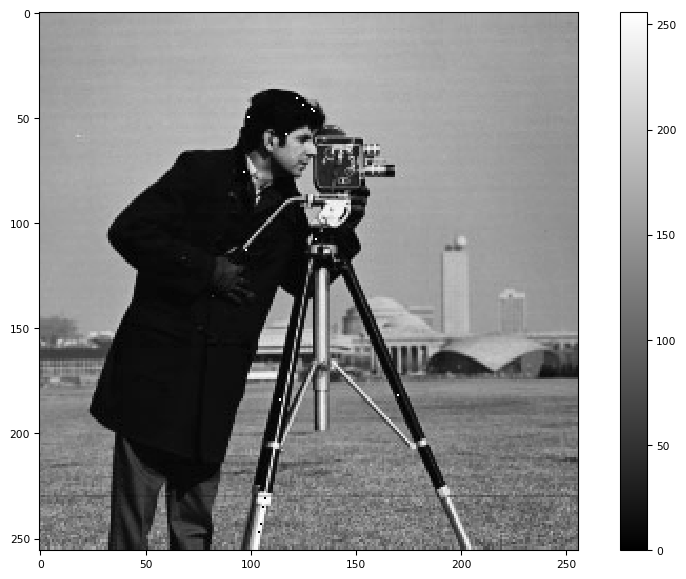

In [99]:
tiff.imshow(reformed_img, cmap='gray')

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fde2bd4ba10>)

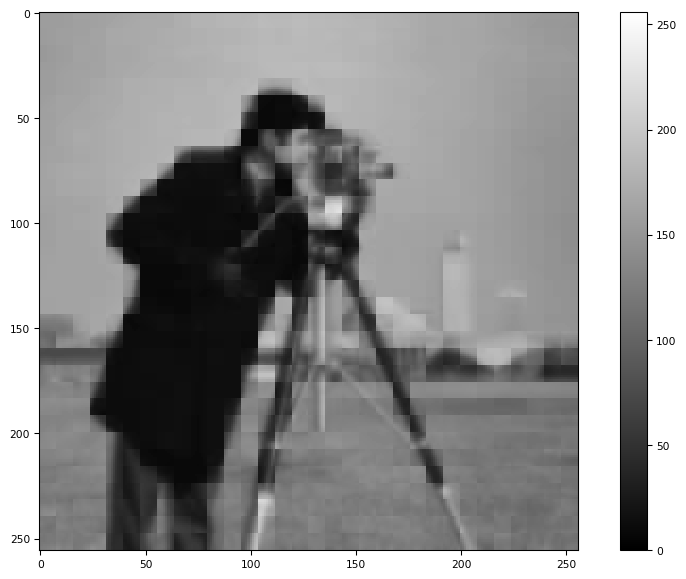

In [100]:
tiff.imshow(reformed_img_H, cmap='gray')

#Comparison

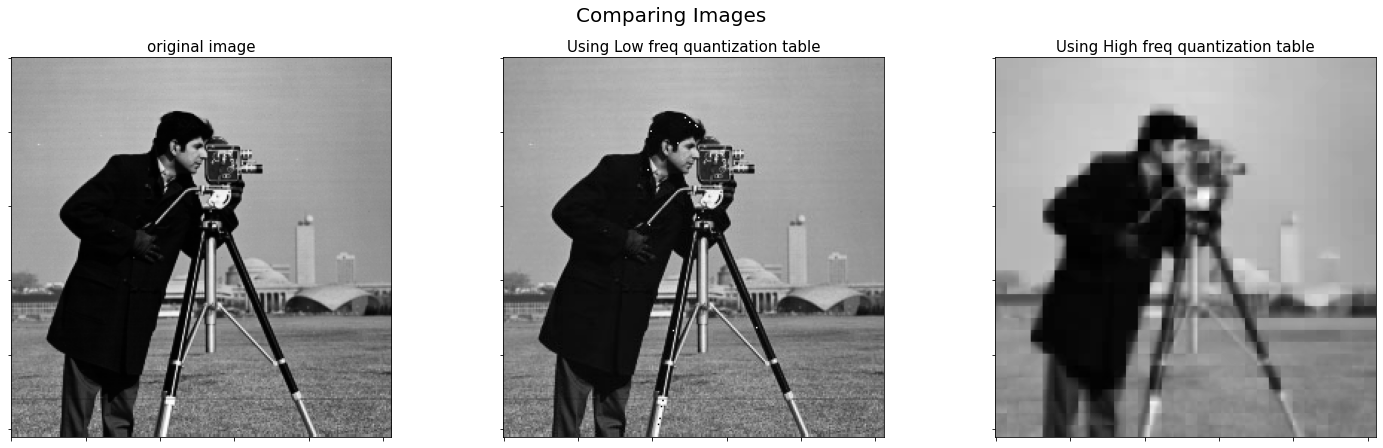

In [101]:
from matplotlib import pyplot as plt
X=[img,reformed_img,reformed_img_H]
Y=['original image','Using Low freq quantization table','Using High freq quantization table']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
fig.suptitle( "Comparing Images", fontsize=20)

for i in range(3):
  ax[i].set_title("{}".format(Y[i]), fontsize=15)
  ax[i].imshow(X[i], cmap='gray') # display the image in as gray colors.
  plt.setp(ax[i].get_xticklabels(), visible=False)#switch off the x axis
  plt.setp(ax[i].get_yticklabels(), visible=False)#switch off the y axis
fig.subplots_adjust(hspace=0.5)

We can notice that dividing by high freq quantization table causes the image to be blurry.

In [102]:
print("The compression ratio is:{}".format(compression_ratio_L))

The compression ratio is:64.0
